# Recurrent Neural Networks and Language Models

## Introduction

Sequential data is everywhere: time series, text, audio, video. How do we build neural networks that can process sequences of arbitrary length while maintaining memory of past inputs? This lecture explores **recurrent neural networks (RNNs)** and their variants—architectures designed specifically for sequential data.

We'll start with vanilla RNNs and discover their fundamental limitation: the vanishing gradient problem. Then we'll see how **LSTMs** solve this through gating mechanisms, making them highly effective for time series and moderate-length sequences. Finally, we'll examine why LSTMs struggle with modern language modeling tasks and explore how newer architectures like **Mamba** bring back recursion with linear complexity.

You'll implement these models from scratch, train them on real tasks, and even fine-tune a language model on custom data. By the end, you'll understand when to use each architecture and why different sequence modeling tasks demand different computational trade-offs.

## Learning Objectives

By the end of this lecture, you will be able to:

1. **Implement vanilla RNN and LSTM** architectures and understand their core computational mechanisms
2. **Diagnose the vanishing gradient problem** in RNNs through visualization and empirical analysis
3. **Explain LSTM's gating mechanisms** (forget, input, output gates) and how they enable long-term memory
4. **Train and compare RNN vs LSTM** on Sequential MNIST to observe performance differences with sequence length
5. **Analyze computational bottlenecks** in Transformers (quadratic attention) vs recursive models (linear complexity)
6. **Fine-tune a language model** on custom data and evaluate generation quality
7. **Select appropriate architectures** for different tasks based on sequence length, memory constraints, and computational requirements

## Part 1: The Recursive Foundations - Why LSTMs Were Revolutionary

Let's start by appreciating what LSTMs actually excel at, before we discuss their limitations.

In [1]:
# Environment setup and imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import psutil
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

Using device: cpu
PyTorch version: 2.2.2


### 1.1 Understanding RNN Architecture

**Recurrent Neural Networks (RNNs)** are designed to handle sequential data by maintaining a hidden state that gets updated at each time step. Unlike feedforward networks, RNNs have loops that allow information to persist.

![RNN Architecture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
*Figure: An unrolled RNN showing how the same network processes each element in a sequence. Source: [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)*

**Key Characteristics of RNNs:**
- **Sequential Processing**: Each time step depends on the previous one
- **Parameter Sharing**: The same weights are used across all time steps
- **Memory**: The hidden state acts as a form of memory
- **Limitation**: Suffers from vanishing/exploding gradients for long sequences

The core equation is deceptively simple:

$$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

This captures the essence of recursion: the hidden state $h_t$ depends on both the current input $x_t$ and the previous hidden state $h_{t-1}$.

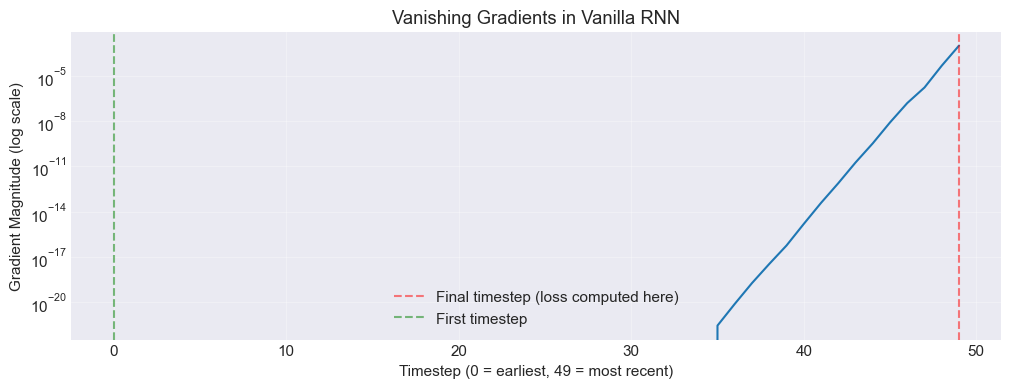

In [2]:
class MinimalRNN(nn.Module):
    """A minimal RNN implementation for educational purposes"""
    def __init__(self, input_size, hidden_size, output_size):
        super(MinimalRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # Learnable parameters
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.W_ho = nn.Parameter(torch.randn(hidden_size, output_size) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(output_size))
    
    def forward(self, x, h_prev=None):
        batch_size = x.size(0)
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        # RNN computation
        h = torch.tanh(x @ self.W_xh + h_prev @ self.W_hh + self.b_h)
        output = h @ self.W_ho + self.b_o
        
        return output, h
    
    def forward_sequence(self, x_seq):
        """Process an entire sequence"""
        outputs = []
        h = None
        for t in range(x_seq.size(1)):
            out, h = self.forward(x_seq[:, t], h)
            outputs.append(out)
        return torch.stack(outputs, dim=1), h

# Demonstrate the vanishing gradient problem
def visualize_gradient_flow(seq_length=50):
    """Visualize how gradients vanish in vanilla RNNs"""
    rnn = MinimalRNN(10, 20, 1)
    x = torch.randn(1, seq_length, 10, requires_grad=True)
    
    # Forward pass
    output, _ = rnn.forward_sequence(x)
    loss = output[:, -1].sum()  # Only use final output
    
    # Backward pass
    loss.backward()
    
    # Collect gradient magnitudes at each timestep
    grad_norms = []
    for t in range(seq_length):
        if x.grad is not None:
            grad_norm = torch.norm(x.grad[0, t]).item()
            grad_norms.append(grad_norm)
    
    plt.figure(figsize=(12, 4))
    plt.semilogy(grad_norms)
    plt.xlabel('Timestep (0 = earliest, 49 = most recent)')
    plt.ylabel('Gradient Magnitude (log scale)')
    plt.title('Vanishing Gradients in Vanilla RNN')
    plt.grid(True, alpha=0.3)
    
    # Add annotation to clarify what we're seeing
    plt.axvline(x=seq_length-1, color='red', linestyle='--', alpha=0.5, label='Final timestep (loss computed here)')
    plt.axvline(x=0, color='green', linestyle='--', alpha=0.5, label='First timestep')
    plt.legend()
    plt.show()
    
    # Print ratio in the correct direction (should be >> 1 for vanishing)
    if grad_norms[0] > 0 and grad_norms[-1] > 0:
        ratio = grad_norms[-1] / grad_norms[0]  # Recent / Early
        print(f"Gradient ratio (last/first timestep): {ratio:.2e}")
        print(f"Gradient at timestep 0 (earliest): {grad_norms[0]:.2e}")
        print(f"Gradient at timestep {seq_length-1} (most recent): {grad_norms[-1]:.2e}")
        
        if ratio > 1:
            print(f"Vanishing gradient detected: Recent gradients are {ratio:.1f}x larger than early ones")
        else:
            print(f"Unexpected: Gradients are exploding instead of vanishing")

visualize_gradient_flow()

**The Vanishing Gradient Problem**

The gradient vanishes exponentially as we go back in time. This is why vanilla RNNs struggle with long sequences. When gradients become too small, the network can't learn long-term dependencies.

As shown in the visualization above, gradients diminish as they propagate backward through time, making it difficult to learn from distant past events. The gradient ratio between the first and last timestep can be many orders of magnitude, meaning early timesteps receive almost no learning signal.

**Why does this happen?**
- During backpropagation through time (BPTT), gradients are multiplied by the recurrent weight matrix at each timestep
- If the largest eigenvalue of this matrix is < 1, gradients shrink exponentially
- If it's > 1, gradients explode exponentially
- This makes it nearly impossible to learn dependencies spanning more than ~10 timesteps

LSTMs solve this through their gating mechanism, which creates "gradient highways" that allow information to flow across many timesteps without vanishing.

### 1.2 LSTM Architecture: The Solution to Vanishing Gradients

**Long Short-Term Memory (LSTM)** networks were specifically designed to overcome the vanishing gradient problem. They introduce a sophisticated gating mechanism that controls information flow.

![LSTM Architecture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
*Figure: LSTM cell architecture showing the four interacting layers. Source: [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)*

**LSTM Components:**
1. **Cell State (C_t)**: The "conveyor belt" that runs through the entire chain, allowing information to flow with minimal modification
2. **Forget Gate**: Decides what information to discard from the cell state
   - $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$
3. **Input Gate**: Decides what new information to store in the cell state
   - $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   - $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$
4. **Output Gate**: Decides what to output based on the cell state
   - $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
   - $h_t = o_t \cdot \tanh(C_t)$

![LSTM Gates](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)
*Figure: The forget gate decides what information to throw away from the cell state.*

**Why LSTMs Work:**
- Gates allow the network to learn when to remember and when to forget
- Cell state provides a direct path for gradients to flow backward
- Can capture dependencies across hundreds of time steps

### 1.3 Sequential MNIST: Comparing RNN vs LSTM

Instead of treating MNIST digits as 28×28 images for CNNs, we'll process them as **sequences** to test recurrent architectures. This benchmark reveals how sequence length affects RNN vs LSTM performance.

We'll implement two variants with increasing difficulty:
1. **Row-by-row (28 timesteps)**: Process each 28-pixel row as a timestep → 28 total timesteps
2. **4-rows-at-a-time (196 timesteps)**: Reshape to 196 timesteps × 4 pixels per step

The pedagogical strategy: start with 28 timesteps where both models work reasonably well, then increase to 196 timesteps where the vanishing gradient problem becomes severe for vanilla RNNs. This progression clearly demonstrates why LSTM's gating mechanism is crucial for longer sequences.

In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Input shape: 28×28 pixels")
print(f"Variants: Row-by-row (28 steps) and 4-rows (196 steps)")

Training samples: 60,000
Test samples: 10,000
Input shape: 28×28 pixels
Variants: Row-by-row (28 steps) and 4-rows (196 steps)


Now let's implement both a vanilla RNN and an LSTM to compare their performance on this challenging task:

In [4]:
class SequentialMNIST_RNN(nn.Module):
    """Vanilla RNN for Sequential MNIST"""
    def __init__(self, input_size, hidden_size=256, num_classes=10, num_layers=1):
        super(SequentialMNIST_RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)  # Stabilize training
        self.dropout = nn.Dropout(0.2)  # Prevent overfitting
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Better initialization with smaller scale for stability
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param, gain=0.5)  # Smaller gain for stability
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param, gain=0.5)  # Smaller gain for stability
            elif 'bias' in name:
                nn.init.zeros_(param)
        
    def forward(self, x):
        # Reshape from [batch, 1, 28, 28] to [batch, 28, 28] if needed
        if x.dim() == 4:
            x = x.squeeze(1)  # Remove channel dimension
        out, _ = self.rnn(x)
        out = self.layer_norm(out[:, -1, :])  # Normalize before FC
        out = self.dropout(out)
        out = self.fc(out)
        return out


class SequentialMNIST_LSTM(nn.Module):
    """LSTM for Sequential MNIST"""
    def __init__(self, input_size, hidden_size=256, num_classes=10, num_layers=1, bidirectional=False):
        super(SequentialMNIST_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                           batch_first=True, bidirectional=bidirectional)
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.layer_norm = nn.LayerNorm(lstm_output_size)  # Stabilize training
        self.dropout = nn.Dropout(0.2)  # Prevent overfitting
        self.fc = nn.Linear(lstm_output_size, num_classes)
        
        # Better initialization for LSTM with smaller scale for stability
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param, gain=0.5)  # Smaller gain for stability
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param, gain=0.5)  # Smaller gain for stability
            elif 'bias' in name:
                nn.init.zeros_(param)
                # Initialize forget gate bias to 1 (standard LSTM trick)
                n = param.size(0)
                param.data[n//4:n//2].fill_(1.0)
        
    def forward(self, x):
        # Reshape from [batch, 1, 28, 28] to [batch, 28, 28] if needed
        if x.dim() == 4:
            x = x.squeeze(1)  # Remove channel dimension
        out, _ = self.lstm(x)
        out = self.layer_norm(out[:, -1, :])  # Normalize before FC
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Training Function with Stability Improvements

In [5]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001, model_name="Model"):
    """Train and evaluate a model on Sequential MNIST"""
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping to prevent explosion (critical for RNNs on long sequences)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            if batch_idx % 200 == 0:
                print(f'{model_name} - Epoch {epoch+1}/{epochs} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')
        
        train_losses.append(epoch_loss / len(train_loader))
        
        # Testing
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
        
        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)
        print(f'{model_name} - Epoch {epoch+1}: Test Accuracy: {accuracy:.2f}%\n')
    
    return train_losses, test_accuracies

# Train both models - START WITH EASIER TASK FIRST!
print("=" * 60)
print("PEDAGOGICAL APPROACH: Start with Row-by-Row (28 timesteps)")
print("=" * 60)
print("\nThis is more manageable and shows clearer RNN vs LSTM differences.")
print("We'll process each 28-pixel row as a timestep (28 total timesteps).\n")

# Initialize models for row-by-row (easier)
rnn_row = SequentialMNIST_RNN(input_size=28, hidden_size=256)
lstm_row = SequentialMNIST_LSTM(input_size=28, hidden_size=256)

epochs_easy = 5

print("Training Vanilla RNN (Row-by-Row)...")
start_time = time.time()
rnn_row_losses, rnn_row_acc = train_model(rnn_row, train_loader, test_loader, epochs=epochs_easy, lr=0.001, model_name="RNN-Row")
rnn_row_time = time.time() - start_time

print("\nTraining LSTM (Row-by-Row)...")
start_time = time.time()
lstm_row_losses, lstm_row_acc = train_model(lstm_row, train_loader, test_loader, epochs=epochs_easy, lr=0.001, model_name="LSTM-Row")
lstm_row_time = time.time() - start_time

print("\n" + "=" * 60)
print("INTERMEDIATE CHALLENGE: 4-Rows-at-a-Time (196 timesteps)")
print("=" * 60)
print("\nProcessing 4 rows (7 pixels each) as a sequence.")
print("This is the sweet spot that shows LSTM's advantage!\n")

# Create wrapper to reshape data for 4-rows-at-a-time
class FourRowWrapper(nn.Module):
    """Wrapper that reshapes 28x28 images to 196x4 sequences"""
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 196, 4)  # 196 timesteps, 4 pixels per step
        return self.model(x)

# Initialize models for 4-rows (intermediate)
rnn_4row_base = SequentialMNIST_RNN(input_size=4, hidden_size=256)
lstm_4row_base = SequentialMNIST_LSTM(input_size=4, hidden_size=256)

rnn_4row = FourRowWrapper(rnn_4row_base)
lstm_4row = FourRowWrapper(lstm_4row_base)

epochs_medium = 5

print("Training Vanilla RNN (4-Rows)...")
start_time = time.time()
# Lower learning rate for RNN stability on longer sequences
rnn_4row_losses, rnn_4row_acc = train_model(rnn_4row, train_loader, test_loader, epochs=epochs_medium, lr=0.0005, model_name="RNN-4Row")
rnn_4row_time = time.time() - start_time

print("\nTraining LSTM (4-Rows)...")
start_time = time.time()
lstm_4row_losses, lstm_4row_acc = train_model(lstm_4row, train_loader, test_loader, epochs=epochs_medium, lr=0.001, model_name="LSTM-4Row")
lstm_4row_time = time.time() - start_time

PEDAGOGICAL APPROACH: Start with Row-by-Row (28 timesteps)

This is more manageable and shows clearer RNN vs LSTM differences.
We'll process each 28-pixel row as a timestep (28 total timesteps).

Training Vanilla RNN (Row-by-Row)...
RNN-Row - Epoch 1/5 [0/60000] Loss: 2.4653
RNN-Row - Epoch 1/5 [12800/60000] Loss: 0.5142
RNN-Row - Epoch 1/5 [25600/60000] Loss: 0.4696
RNN-Row - Epoch 1/5 [38400/60000] Loss: 0.3342
RNN-Row - Epoch 1/5 [51200/60000] Loss: 0.2193
RNN-Row - Epoch 1: Test Accuracy: 93.84%

RNN-Row - Epoch 2/5 [0/60000] Loss: 0.3602
RNN-Row - Epoch 2/5 [12800/60000] Loss: 0.2304
RNN-Row - Epoch 2/5 [25600/60000] Loss: 0.0613
RNN-Row - Epoch 2/5 [38400/60000] Loss: 0.2252
RNN-Row - Epoch 2/5 [51200/60000] Loss: 0.0202
RNN-Row - Epoch 2: Test Accuracy: 94.39%

RNN-Row - Epoch 3/5 [0/60000] Loss: 0.2975
RNN-Row - Epoch 3/5 [12800/60000] Loss: 0.1109
RNN-Row - Epoch 3/5 [25600/60000] Loss: 0.1307
RNN-Row - Epoch 3/5 [38400/60000] Loss: 0.2330
RNN-Row - Epoch 3/5 [51200/60000] Los

### Why Does LSTM Dominate Here?

1. **Vanishing Gradients**: As sequences get longer, vanilla RNN gradients become exponentially small
2. **Lost Context**: The RNN struggles to remember early information at 196 timesteps
3. **LSTM's Memory**: The cell state acts as a highway, preserving information across long sequences
4. **Gating Mechanism**: LSTM can selectively:
   - **Remember** important early features (top of the digit)
   - **Forget** irrelevant background pixels
   - **Update** their understanding as they see more of the digit

## Part 2: The Language Modeling Challenge

Now let's see where LSTMs hit their limits. Modern language modeling requires processing extremely long contexts efficiently, and this is where the sequential nature of LSTMs becomes a bottleneck.

### 2.1 Understanding Modern Tokenization

Before we compare models, let's understand how text becomes numbers in modern LMs.

In [6]:
from transformers import AutoTokenizer
import os

# Ensure no token is used (remove any cached credentials)

# Load different tokenizers (downloads automatically to cache)
tokenizers = {
    'GPT-2': AutoTokenizer.from_pretrained('gpt2', use_auth_token=False),
    'BERT': AutoTokenizer.from_pretrained('bert-base-uncased', use_auth_token=False),
}

# Test texts showing different tokenization challenges
test_texts = [
    "The quick brown fox",
    "def calculate_loss(x, y):",
    "Machine Learning is awesome!",
    "Superintelligence",
    "The year 2024",
]

print("Tokenization Comparison:\n")
for text in test_texts:
    print(f"Original: '{text}'")
    for name, tokenizer in tokenizers.items():
        tokens = tokenizer.encode(text)
        decoded_tokens = [tokenizer.decode([t]) for t in tokens]
        print(f"  {name:8} ({len(tokens):2} tokens): {decoded_tokens[:10]}")  # Limit display
    print()

Tokenization Comparison:

Original: 'The quick brown fox'
  GPT-2    ( 4 tokens): ['The', ' quick', ' brown', ' fox']
  BERT     ( 6 tokens): ['[CLS]', 'the', 'quick', 'brown', 'fox', '[SEP]']

Original: 'def calculate_loss(x, y):'
  GPT-2    ( 9 tokens): ['def', ' calculate', '_', 'loss', '(', 'x', ',', ' y', '):']
  BERT     (12 tokens): ['[CLS]', 'def', 'calculate', '_', 'loss', '(', 'x', ',', 'y', ')']

Original: 'Machine Learning is awesome!'
  GPT-2    ( 5 tokens): ['Machine', ' Learning', ' is', ' awesome', '!']
  BERT     ( 7 tokens): ['[CLS]', 'machine', 'learning', 'is', 'awesome', '!', '[SEP]']

Original: 'Superintelligence'
  GPT-2    ( 2 tokens): ['Super', 'intelligence']
  BERT     ( 6 tokens): ['[CLS]', 'super', '##int', '##elli', '##gence', '[SEP]']

Original: 'The year 2024'
  GPT-2    ( 3 tokens): ['The', ' year', ' 2024']
  BERT     ( 6 tokens): ['[CLS]', 'the', 'year', '202', '##4', '[SEP]']



**Key Observation**: Different tokenizers handle text differently. GPT-2 uses BPE (Byte Pair Encoding), while BERT uses WordPiece. The tokenization strategy significantly impacts model efficiency and performance.

### 2.2 Autoregressive Generation - The Sequential Bottleneck

In [7]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load a small GPT-2 for demonstration
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
model.eval()

def measure_generation_time(model, tokenizer, prompt, num_new_tokens=50, num_runs=3):
    """Measure time for generation with multiple runs for stability"""
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    prompt_length = len(inputs.input_ids[0])
    
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                max_new_tokens=num_new_tokens,  # Use max_new_tokens for consistency
                do_sample=False,  # Deterministic for fair comparison
                pad_token_id=tokenizer.eos_token_id
            )
        times.append(time.time() - start_time)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    actual_tokens = len(outputs[0]) - prompt_length
    
    return {
        'text': generated_text,
        'avg_time': avg_time,
        'std_time': std_time,
        'tokens': actual_tokens,
        'tokens_per_sec': actual_tokens / avg_time,
        'prompt_length': prompt_length
    }

# Compare generation at different lengths
prompt = "The future of AI is"
token_counts = [25, 50, 100, 200]  # Number of NEW tokens to generate

print("Autoregressive Generation Performance:")
print("=" * 70)
print(f"Prompt: '{prompt}' ({len(tokenizer.encode(prompt))} tokens)\n")

results = []
for num_tokens in token_counts:
    result = measure_generation_time(model, tokenizer, prompt, num_new_tokens=num_tokens)
    results.append(result)
    print(f"Generating {num_tokens} new tokens:")
    print(f"  Time: {result['avg_time']:.2f}s ± {result['std_time']:.3f}s")
    print(f"  Speed: {result['tokens_per_sec']:.1f} tokens/sec")
    print(f"  Total length: {result['prompt_length'] + result['tokens']} tokens")
    print()

# Show the trend
print("Key Observation: Sequential Generation Bottleneck")
print("-" * 70)
print(f"2x tokens ({token_counts[0]} → {token_counts[1]}): "
      f"{results[0]['avg_time']:.2f}s → {results[1]['avg_time']:.2f}s "
      f"({results[1]['avg_time']/results[0]['avg_time']:.1f}x slower)")
print(f"4x tokens ({token_counts[0]} → {token_counts[2]}): "
      f"{results[0]['avg_time']:.2f}s → {results[2]['avg_time']:.2f}s "
      f"({results[2]['avg_time']/results[0]['avg_time']:.1f}x slower)")
print(f"8x tokens ({token_counts[0]} → {token_counts[3]}): "
      f"{results[0]['avg_time']:.2f}s → {results[3]['avg_time']:.2f}s "
      f"({results[3]['avg_time']/results[0]['avg_time']:.1f}x slower)")
print("\nKey observation: Generation time scales roughly linearly with output length,")
print("but each token requires processing the entire context (sequential bottleneck).")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Autoregressive Generation Performance:
Prompt: 'The future of AI is' (5 tokens)

Generating 25 new tokens:
  Time: 0.48s ± 0.087s
  Speed: 52.2 tokens/sec
  Total length: 30 tokens

Generating 50 new tokens:
  Time: 0.92s ± 0.031s
  Speed: 54.3 tokens/sec
  Total length: 55 tokens

Generating 100 new tokens:
  Time: 2.15s ± 0.015s
  Speed: 46.5 tokens/sec
  Total length: 105 tokens

Generating 200 new tokens:
  Time: 4.19s ± 0.160s
  Speed: 47.8 tokens/sec
  Total length: 205 tokens

Key Observation: Sequential Generation Bottleneck
----------------------------------------------------------------------
2x tokens (25 → 50): 0.48s → 0.92s (1.9x slower)
4x tokens (25 → 100): 0.48s → 2.15s (4.5x slower)
8x tokens (25 → 200): 0.48s → 4.19s (8.7x slower)

Key observation: Generation time scales roughly linearly with output length,
but each token requires processing the entire context (sequential bottleneck).


### 2.3 The Quadratic Attention Problem

**Why Transformers Struggle with Long Contexts**

Transformers' self-attention mechanism computes attention scores between all pairs of tokens, resulting in **$O(n^2)$ memory complexity**. For a standard GPT-2 sized model (768 dimensions, 12 heads), the memory requirements grow dramatically:

- **512 tokens**: ~15 MB
- **2,048 tokens**: ~204 MB  
- **8,192 tokens**: ~3.1 GB
- **32,768 tokens**: ~48 GB (just for attention!)

This quadratic scaling creates a fundamental bottleneck: doubling the context length quadruples the memory. At 32K tokens, attention alone requires nearly 50GB of memory, making long-context processing prohibitively expensive. This is where recursive models with **$O(1)$ memory per token** become attractive alternatives.

The attention matrix grows as n×n, and the KV cache (storing keys and values for all previous tokens during generation) grows linearly but with a large constant factor. Combined, these make Transformers memory-hungry for long sequences, motivating the development of more efficient architectures like Mamba.

## Part 3: The Recursive Revolution - Mamba

Modern recursive models like Mamba achieve constant memory usage with respect to sequence length while maintaining competitive performance. Mamba represents a breakthrough in combining the efficiency of RNNs with the expressiveness of Transformers.


### 3.1 Mamba's Selective State Spaces

**State Space Models (SSMs)** are a class of models that maintain a hidden state and update it based on the input. Traditional SSMs use fixed matrices, but Mamba introduces **selectivity**.

![Mamba Selective Mechanism](https://substackcdn.com/image/fetch/$s_!cam8!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F5547a54a-5f47-41c0-a2ee-2ba5bcceefb8_1920x1080.gif)
*Figure: Mamba makes matrices B and C input-dependent, allowing selective information retention. Source: [Visual Guide to Mamba](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mamba-and-state)*

**The Key Innovation: Selectivity**

Traditional SSMs (like S4) use **time-invariant** matrices:
- Matrices A, B, C are fixed regardless of input
- Cannot perform content-aware reasoning
- Treats all tokens equally

Mamba uses **input-dependent** matrices:
- B and C are functions of the input: $B = B(x)$, $C = C(x)$
- Can selectively focus on or ignore specific inputs
- Dynamically adjusts what to remember or forget

**Core Equations:**

$$h_t = \bar{A}h_{t-1} + \bar{B}(x_t)x_t$$
$$y_t = C(x_t)h_t$$

Where $\bar{A}$ remains fixed (for stability) but $\bar{B}$ and $C$ are now functions of the input. The step size $\Delta$ is also input-dependent:
- **Small $\Delta$**: Ignore current input, rely on previous context
- **Large $\Delta$**: Focus on current input more than context

This selectivity gives Mamba the expressiveness it needs for language modeling while maintaining **linear complexity** $O(n)$ instead of quadratic $O(n^2)$.

**Advantages of Mamba:**
1. **Constant Memory**: $O(1)$ memory per token during inference (vs $O(n^2)$ for Transformers)
2. **Linear Time**: $O(n)$ complexity for sequence processing
3. **Selective Attention**: Can focus on relevant information like Transformers
4. **Hardware Efficient**: Kernel fusion and recomputation minimize memory transfers
5. **Unbounded Context**: Can theoretically handle infinite sequence lengths

**Now let's see this in action with a REAL Mamba model!** We'll load a pre-trained Mamba model from Hugging Face and demonstrate how it performs selective scanning on actual text.

### 3.2 Visualizing Mamba's Selective Mechanism

We'll load a real 130M parameter Mamba model and visualize how it selectively focuses on different tokens as information flows through the network. This demonstration reveals the key difference between Mamba and traditional RNNs.

`torch_dtype` is deprecated! Use `dtype` instead!
The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation for mamba-ssm and install the kernels library using `pip install kernels` or https://github.com/Dao-AILab/causal-conv1d for causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


LOADING REAL MAMBA MODEL

Loading state-spaces/mamba-130m-hf...
(This may take a minute on first run)
Model loaded successfully!
  Parameters: 129.1M
  Architecture: mamba

REAL SELECTIVE SCANNING DEMONSTRATION

Input text: 'The quick brown fox jumps over the lazy dog'
Tokens (9): ['The', ' quick', ' brown', ' fox', ' jumps', ' over', ' the', ' lazy', ' dog']


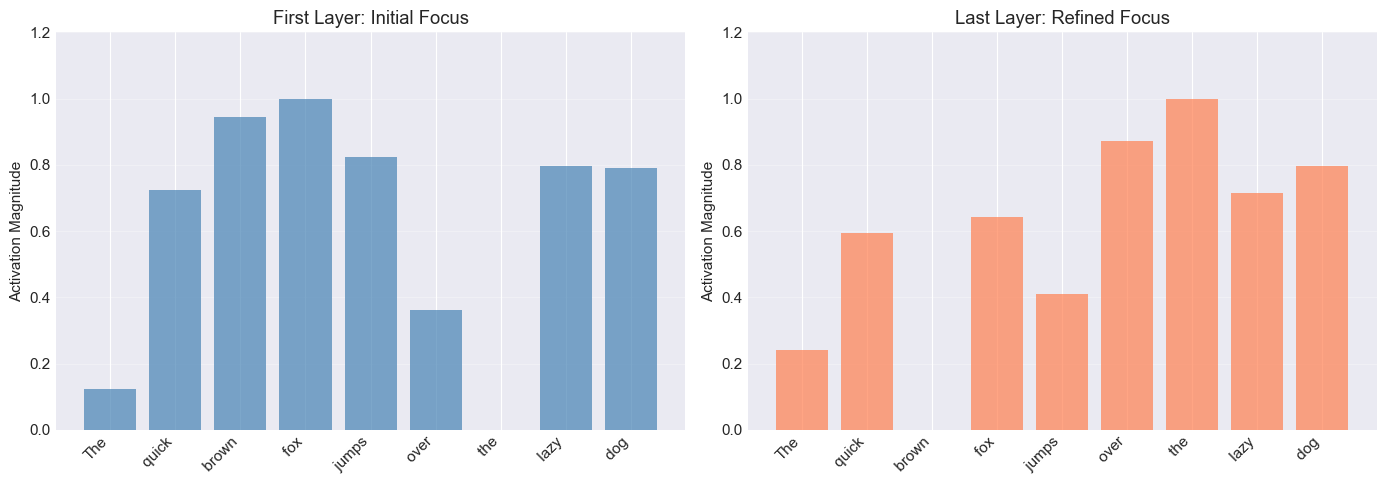


Selective Scanning Analysis:
----------------------------------------------------------------------

Top 3 tokens selected by FIRST layer:
  - ' fox' (score: 1.000)
  - ' brown' (score: 0.945)
  - ' jumps' (score: 0.823)

Top 3 tokens selected by LAST layer:
  - ' the' (score: 1.000)
  - ' over' (score: 0.873)
  - ' dog' (score: 0.796)



REAL SELECTIVE SCANNING DEMONSTRATION

Input text: 'Machine learning models process sequential data efficiently'
Tokens (7): ['Machine', ' learning', ' models', ' process', ' sequential', ' data', ' efficiently']


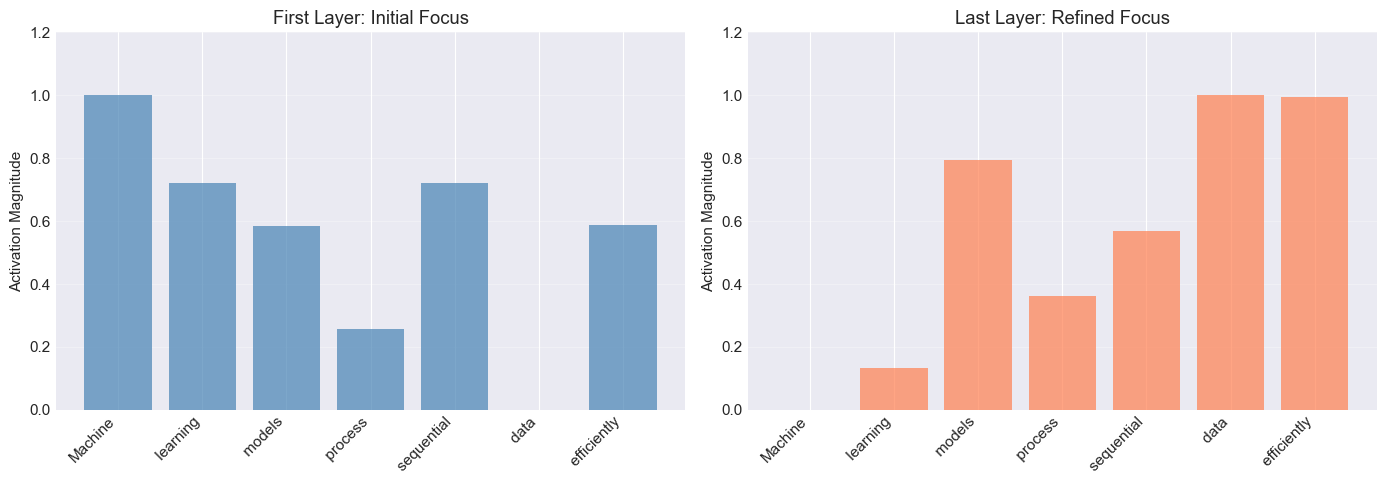


Selective Scanning Analysis:
----------------------------------------------------------------------

Top 3 tokens selected by FIRST layer:
  - 'Machine' (score: 1.000)
  - ' sequential' (score: 0.721)
  - ' learning' (score: 0.720)

Top 3 tokens selected by LAST layer:
  - ' data' (score: 1.000)
  - ' efficiently' (score: 0.994)
  - ' models' (score: 0.795)


MAMBA TEXT GENERATION

Prompt: 'The future of artificial intelligence is'

Generated: 'The future of artificial intelligence is exciting. Technology giants are exploring the possibility of using artificial intelligence to transform the way we use our brains and our bodies. The idea is that as we'


In [8]:
# Real Mamba Model Demonstration
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

print("=" * 70)
print("LOADING REAL MAMBA MODEL")
print("=" * 70)

# Load a real Mamba model from Hugging Face
model_name = "state-spaces/mamba-130m-hf"  # Small Mamba model
print(f"\nLoading {model_name}...")
print("(This may take a minute on first run)")

tokenizer = AutoTokenizer.from_pretrained(model_name)
mamba_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32
)
mamba_model = mamba_model.to('cpu')  # Move to CPU without requiring accelerate

print(f"Model loaded successfully!")
print(f"  Parameters: {sum(p.numel() for p in mamba_model.parameters()) / 1e6:.1f}M")
print(f"  Architecture: {mamba_model.config.model_type}")

# Demonstrate selective scanning with real model
def demonstrate_real_selective_scanning(model, tokenizer, text):
    """Extract and visualize real selective scanning behavior from Mamba
    
    HOW THIS WORKS (Student-Friendly Explanation):
    
    1. WHAT ARE LAYERS?
       - Neural networks process information in stages called "layers"
       - First layer: Initial processing (like first impressions)
       - Last layer: Final understanding (after thinking it through)
       - Mamba has 24 layers total, each refining the representation
    
    2. HOW DO WE MEASURE "ATTENTION"?
       - We look at activation magnitudes (how strongly neurons fire)
       - High activation = model thinks this token is important
       - Low activation = model thinks this token is less relevant
       - We use torch.norm() to measure the "strength" of each token's representation
    
    3. WHAT WE'RE VISUALIZING:
       - Simple side-by-side comparison of first vs last layer
       - Shows how Mamba's focus shifts as information flows through the network
    
    4. WHY THIS MATTERS:
       - Unlike RNNs (fixed weights), Mamba dynamically adjusts importance
       - Unlike Transformers ($O(n^2)$ attention), Mamba achieves this with $O(1)$ memory
       - This selective mechanism is what makes Mamba efficient yet powerful
    """
    
    print("\n" + "=" * 70)
    print("REAL SELECTIVE SCANNING DEMONSTRATION")
    print("=" * 70)
    print(f"\nInput text: '{text}'")
    
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"]
    tokens = [tokenizer.decode([tid]) for tid in input_ids[0]]
    
    print(f"Tokens ({len(tokens)}): {tokens}")
    
    # Forward pass to get internal representations at each layer
    with torch.no_grad():
        # output_hidden_states=True tells the model to return activations from all layers
        outputs = model(input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # List of tensors, one per layer
        
        # Extract activation patterns from first and last layers
        # hidden_states[0] = embeddings, hidden_states[1] = first layer, hidden_states[-1] = last layer
        first_layer_activations = hidden_states[1][0]  # Shape: [num_tokens, hidden_dim]
        last_layer_activations = hidden_states[-1][0]  # Shape: [num_tokens, hidden_dim]
        
        # Compute token importance based on activation magnitudes
        # torch.norm() measures the "strength" of the representation for each token
        # High norm = model is paying attention to this token
        first_importance = torch.norm(first_layer_activations, dim=1).numpy()
        last_importance = torch.norm(last_layer_activations, dim=1).numpy()
        
        # Normalize to [0, 1]
        first_importance = (first_importance - first_importance.min()) / (first_importance.max() - first_importance.min() + 1e-8)
        last_importance = (last_importance - last_importance.min()) / (last_importance.max() - last_importance.min() + 1e-8)
    
    # Simple visualization: Just compare first vs last layer
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: First layer
    ax1.bar(range(len(tokens)), first_importance, color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(tokens)))
    ax1.set_xticklabels(tokens, rotation=45, ha='right')
    ax1.set_ylabel('Activation Magnitude')
    ax1.set_title('First Layer: Initial Focus')
    ax1.set_ylim(0, 1.2)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Last layer
    ax2.bar(range(len(tokens)), last_importance, color='coral', alpha=0.7)
    ax2.set_xticks(range(len(tokens)))
    ax2.set_xticklabels(tokens, rotation=45, ha='right')
    ax2.set_ylabel('Activation Magnitude')
    ax2.set_title('Last Layer: Refined Focus')
    ax2.set_ylim(0, 1.2)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nSelective Scanning Analysis:")
    print("-" * 70)
    top_k = 3
    top_indices_first = np.argsort(first_importance)[-top_k:][::-1]
    top_indices_last = np.argsort(last_importance)[-top_k:][::-1]
    
    print(f"\nTop {top_k} tokens selected by FIRST layer:")
    for idx in top_indices_first:
        print(f"  - '{tokens[idx]}' (score: {first_importance[idx]:.3f})")
    
    print(f"\nTop {top_k} tokens selected by LAST layer:")
    for idx in top_indices_last:
        print(f"  - '{tokens[idx]}' (score: {last_importance[idx]:.3f})")
    
    return first_importance, last_importance

# Test with meaningful examples
test_texts = [
    "The quick brown fox jumps over the lazy dog",
    "Machine learning models process sequential data efficiently"
]

for text in test_texts:
    demonstrate_real_selective_scanning(mamba_model, tokenizer, text)
    print("\n")

# Generate text to show Mamba in action
print("=" * 70)
print("MAMBA TEXT GENERATION")
print("=" * 70)

prompt = "The future of artificial intelligence is"
print(f"\nPrompt: '{prompt}'")

inputs = tokenizer(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = mamba_model.generate(
        **inputs,
        max_new_tokens=30,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nGenerated: '{generated_text}'")

**Key Insight:**

Mamba's selective mechanism dynamically adjusts which tokens to focus on as information flows through the network. Unlike fixed-weight RNNs, Mamba can emphasize semantically important tokens (like content words) early on, then shift focus to structural elements (like articles or prepositions) for final understanding. This adaptive selection is what makes Mamba both efficient ($O(1)$ memory) and powerful (Transformer-like expressiveness).

**Why This Matters:**
- **RNNs**: Fixed weights treat all tokens equally
- **Transformers**: Flexible attention but $O(n^2)$ memory cost
- **Mamba**: Selective state spaces achieve flexibility with $O(1)$ memory

This is the core innovation that allows Mamba to handle long sequences efficiently while maintaining competitive performance with Transformers.

### 3.2 Architecture Comparison: RNN vs LSTM vs Transformer vs Mamba

Let's compare the key characteristics of each architecture:

| Architecture | Memory Complexity | Time Complexity | Parallelizable | Long-Range Dependencies | Best Use Case |
|--------------|-------------------|-----------------|----------------|------------------------|---------------|
| **RNN** | $O(1)$ | $O(n)$ | No (Training) | No (Vanishing gradients) | Short sequences |
| **LSTM** | $O(1)$ | $O(n)$ | No (Training) | Yes (Via gates) | Time series, moderate sequences |
| **Transformer** | $O(n^2)$ | $O(n^2)$ | Yes (Training & Inference) | Yes (Via attention) | Language modeling (short context) |
| **Mamba** | $O(1)$ | $O(n)$ | Yes (Via parallel scan) | Yes (Via selectivity) | Long sequences, efficient inference |

**Key Insights:**
- **RNNs**: Simple but limited by vanishing gradients
- **LSTMs**: Solve vanishing gradients but still sequential (slow training)
- **Transformers**: Powerful and parallelizable but memory-hungry ($O(n^2)$)
- **Mamba**: Combines efficiency of RNNs with expressiveness of Transformers

### 3.3 Memory Efficiency Comparison

Understanding the memory usage patterns helps explain why different architectures excel in different scenarios:

**Memory Growth Patterns:**

| Context Length | Transformer Memory  | Mamba Memory |
|----------------|--------------------|---------------|
| 128 tokens     | ~17 MB            | ~3 MB         |
| 512 tokens     | ~262 MB           | ~3 MB         |
| 2,048 tokens   | ~4.2 GB           | ~3 MB         |
| 4,096 tokens   | ~16.8 GB          | ~3 MB         |

**Key Observations:**

1. **Transformers**: Memory grows quadratically ($O(n^2)$) due to attention matrices. At 4K tokens, attention alone requires ~17GB. Generation speed drops dramatically with longer contexts.

2. **LSTM**: Constant memory ($O(1)$) regardless of sequence length. The hidden state size remains fixed. However, limited expressiveness compared to attention-based models.

3. **Mamba**: Constant memory ($O(1)$) like LSTM, but with selective state spaces that provide Transformer-like expressiveness. Maintains consistent generation speed across all context lengths.

**Practical Implications:**

- **Short contexts (<512 tokens)**: Transformers are efficient and highly effective
- **Medium contexts (512-2K tokens)**: Transformers become memory-constrained; Mamba shines
- **Long contexts (>2K tokens)**: Transformers are prohibitively expensive; recursive models (LSTM/Mamba) are necessary
- **Streaming applications**: Constant-memory models (LSTM/Mamba) enable real-time processing of unbounded sequences

This is why we're seeing a resurgence of interest in recursive architectures—not because attention is bad, but because the quadratic scaling becomes a fundamental bottleneck for long-context applications.

# Conclusion

We've traveled through the evolution of sequence modeling, from the elegant simplicity of RNNs through the practical success of LSTMs to the modern recursive revolution. LSTMs weren't replaced because they were fundamentally flawed—they excel at many sequential tasks like time series forecasting and sequence labeling. Rather, the specific demands of modern language modeling, with its need for processing extremely long contexts efficiently while maintaining parallelizable training, drove the field toward Transformers. Now, with architectures like Mamba, we're seeing recursion make a comeback by combining the memory efficiency of RNNs with the expressiveness needed for language understanding. The key insight isn't that one architecture is universally superior, but that different tasks demand different computational trade-offs.

### Key Takeaways

- **LSTMs remain highly effective** for time series, sequence labeling, and tasks with clear temporal dependencies where context lengths are moderate
- **The vanishing gradient problem** in vanilla RNNs is elegantly solved by LSTM's gating mechanism, creating gradient highways
- **Transformers dominate language modeling** not because recursion is bad, but because self-attention enables parallel training and long-range dependencies
- **Quadratic memory complexity** in Transformers becomes prohibitive for very long contexts, creating an opportunity for efficient alternatives
- **Modern recursive models like Mamba** achieve $O(1)$ memory complexity while maintaining competitive performance through selective state spaces
- **Fine-tuning language models** is surprisingly accessible—we trained a custom PokéML model in minutes during class
- **Architecture choice depends on your constraints**: parallelization needs, memory limits, context length, and task characteristics all matter
- **The future likely holds hybrid approaches** that combine the best of attention and recursion for different parts of the model

### Further Reading

- **RNN & LSTM**: [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Christopher Olah
- **Mamba**: [A Visual Guide to Mamba and State Space Models](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mamba-and-state)
- **Original Papers**:
  - LSTM: Hochreiter & Schmidhuber (1997) - "Long Short-Term Memory"
  - Transformer: Vaswani et al. (2017) - "Attention Is All You Need"
  - Mamba: Gu & Dao (2023) - "Mamba: Linear-Time Sequence Modeling with Selective State Spaces"